In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 

--2024-12-10 11:46:58--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-12-10 11:46:58--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: 'food-101.tar.gz'

food-101.tar.gz     100%[===================>]   4.65G  27.6MB/s    in 2m 59s  

2024-12-10 11:49:58 (26.6 MB/s) - 'food-101.tar.gz' saved [4996278331/4996278331]



In [2]:
!tar xzvf food-101.tar.gz

food-101/
food-101/images/
food-101/images/beignets/
food-101/images/beignets/2885220.jpg
food-101/images/beignets/1814040.jpg
food-101/images/beignets/81202.jpg
food-101/images/beignets/1827892.jpg
food-101/images/beignets/2802124.jpg
food-101/images/beignets/2192983.jpg
food-101/images/beignets/250043.jpg
food-101/images/beignets/2786548.jpg
food-101/images/beignets/445116.jpg
food-101/images/beignets/3661460.jpg
food-101/images/beignets/1064858.jpg
food-101/images/beignets/2993714.jpg
food-101/images/beignets/2936669.jpg
food-101/images/beignets/1062952.jpg
food-101/images/beignets/2869806.jpg
food-101/images/beignets/178659.jpg
food-101/images/beignets/1261083.jpg
food-101/images/beignets/1296128.jpg
food-101/images/beignets/3157161.jpg
food-101/images/beignets/646871.jpg
food-101/images/beignets/3438314.jpg
food-101/images/beignets/3019700.jpg
food-101/images/beignets/1133765.jpg
food-101/images/beignets/1199143.jpg
food-101/images/beignets/287665.jpg
food-101/images/beignets/3452

In [3]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

In [4]:
%matplotlib inline

In [5]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [6]:
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

 def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test

In [7]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('/kaggle/working/food-101/train'))
    len_test = len(os.listdir('/kaggle/working/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/kaggle/working/food-101/train'))
    len_test = len(os.listdir('/kaggle/working/food-101/test'))
    print(len_train,len_test)

101 101


In [8]:
# список всех классов еды
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


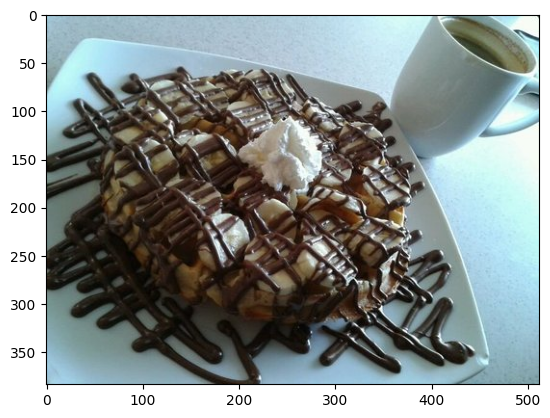

In [ ]:
testImg = imread('food-101/test/waffles/1236559.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [10]:
X_train, y_train, X_test, y_test = load_train_test_data('food-101/train','food-101/test')

In [11]:
X_train.shape

(75750, 200, 200, 3)

In [12]:
X_test.shape

(25250, 200, 200, 3)

In [13]:
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = 'food-101/train'
test_data = 'food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, height, width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, n_classes), dtype=tf.float32)
    )
).repeat()

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, height, width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, n_classes), dtype=tf.float32)
    )
).repeat()

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.keras', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')
history_101class = model.fit(train_ds, steps_per_epoch=train_samples // batch_size, validation_data=test_ds, validation_steps=test_samples // batch_size, epochs=15, callbacks=[csv_logger, checkpointer])

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1733833785.411451      93 service.cc:145] XLA service 0x7a9cfc0025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733833785.411923      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733833785.411929      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/4734 ━━━━━━━━━━━━━━━━━━━━ 67:15:37 51s/step - accuracy: 0.0000e+00 - loss: 5.2332

I0000 00:00:1733833815.187110      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4734/4734 ━━━━━━━━━━━━━━━━━━━━ 896s 179ms/step - accuracy: 0.0312 - loss: 5.0952 - val_accuracy: 0.2147 - val_loss: 4.1750
Epoch 2/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 897s 184ms/step - accuracy: 0.1994 - loss: 4.1807 - val_accuracy: 0.4357 - val_loss: 2.9074
Epoch 3/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 850s 180ms/step - accuracy: 0.3444 - loss: 3.3087 - val_accuracy: 0.5384 - val_loss: 2.3260
Epoch 4/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 835s 177ms/step - accuracy: 0.4336 - loss: 2.8141 - val_accuracy: 0.6004 - val_loss: 1.9928
Epoch 5/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 837s 177ms/step - accuracy: 0.4932 - loss: 2.5079 - val_accuracy: 0.6340 - val_loss: 1.8130
Epoch 6/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 833s 176ms/step - accuracy: 0.5370 - loss: 2.2758 - val_accuracy: 0.6651 - val_loss: 1.6576
Epoch 7/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 836s 177ms/step - accuracy: 0.5699 - loss: 2.1157 - val_accuracy: 0.6793 - val_loss: 1.5712
Epoch 8/15
4734/4734 ━━━━━━━━━━━━━━━━━━━━ 836s 177ms/step - accuracy: 0.5

In [14]:
model.save('model_trained_101class.hdf5')

In [ ]:
class_map_101 = train_gen.class_indices
class_map_101

/tmp/ipykernel_23/1708727014.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


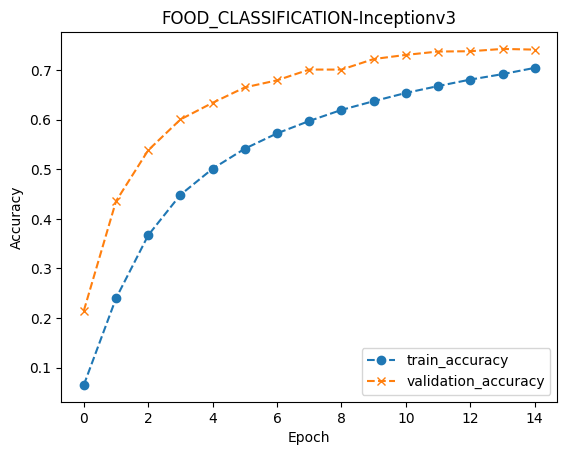

In [15]:

# training-accuracy & validation-accuracy
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()
     

/tmp/ipykernel_23/648717386.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


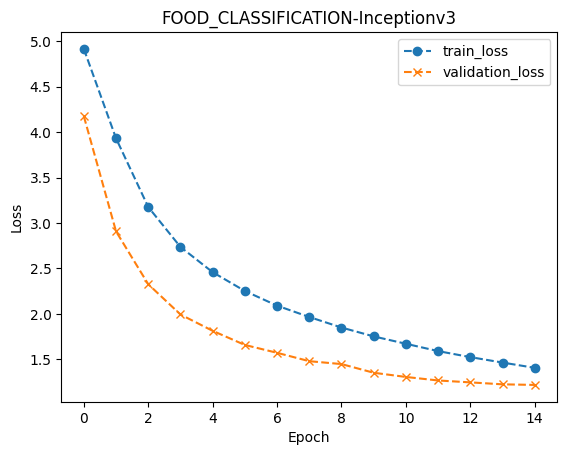

In [16]:

# training-loss & validation-loss
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()
     

In [18]:
# загрузим лучшую модель и поссмотрим что она предсказывает
tensorflow.keras.backend.clear_session()
model_best = load_model('/kaggle/working/best_model_101class.keras',compile = False)
# немного изображений для теста
!wget -O pizza.jpg "https://i.kinja-img.com/gawker-media/image/upload/s--ZkdkfWZf--/c_scale,f_auto,fl_progressive,q_80,w_800/lkw9iemetd2vpfggrard.jpg"
!wget -O frenchfries.jpg "https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg"
!wget -O garlicbread.jpg "https://thebusybaker.ca/wp-content/uploads/2018/08/easy-homemade-garlic-bread-3.jpg"
!wget -O strawberryshortcake.jpg "https://www.cookingclassy.com/wp-content/uploads/2019/03/strawberry-shortcake-02.jpg"
!wget -O kiwi.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Kiwi_%28Actinidia_chinensis%29_1_Luc_Viatour.jpg/440px-Kiwi_%28Actinidia_chinensis%29_1_Luc_Viatour.jpg"
!wget -O eggs.jpg 'https://media.istockphoto.com/id/466512172/ru/фото/две-жареные-яйца-на-черном-пан.jpg?s=2048x2048&w=is&k=20&c=YtMu-s0gyXrpkIRJvLrvozhF-turVtZN8FyhtyCCGCc='

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-10 16:04:07--  https://i.kinja-img.com/gawker-media/image/upload/s--ZkdkfWZf--/c_scale,f_auto,fl_progressive,q_80,w_800/lkw9iemetd2vpfggrard.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.66.166, 151.101.130.166, 151.101.2.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.66.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63110 (62K) [image/jpeg]
Saving to: 'pizza.jpg'

pizza.jpg           100%[===================>]  61.63K  --.-KB/s    in 0.01s   

2024-12-10 16:04:07 (5.15 MB/s) - 'pizza.jpg' saved [63110/63110]

--2024-12-10 16:04:09--  https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg
Resolving www.corriecooks.com (www.corriecooks.com)... 170.249.198.197
Connecting to www.corriecooks.com (www.corriecooks.com)|170.249.198.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68048 (66K) [image/jpeg]
Saving to: 'frenchfries.jpg'

frenchfries.jpg     100%[======

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


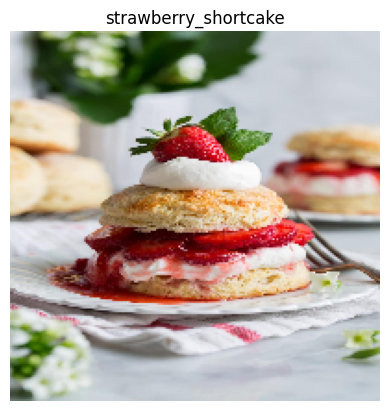

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


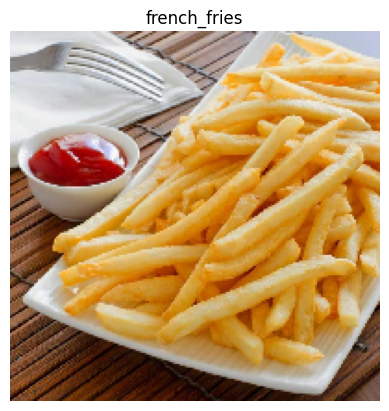

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


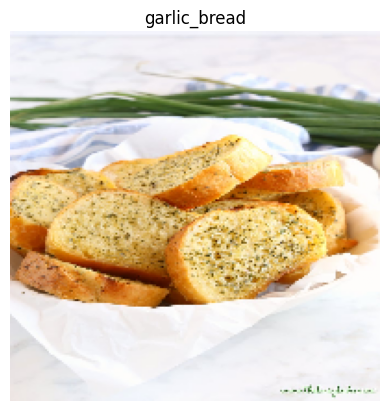

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


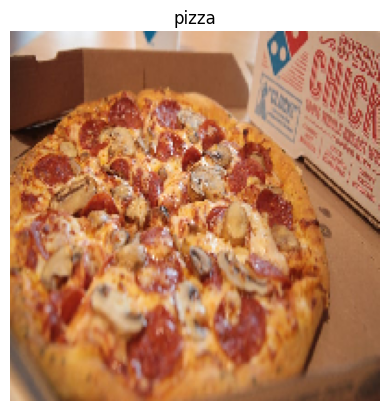

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


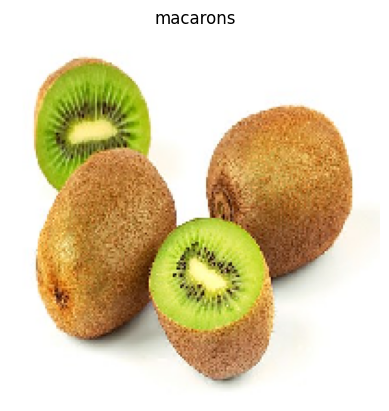

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


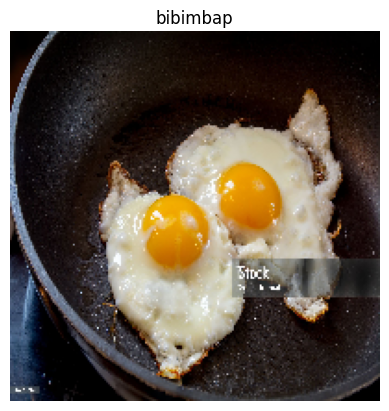

In [19]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = img / 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['strawberryshortcake.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'pizza.jpg', 'kiwi.jpg', 'eggs.jpg']
predict_class(model_best, images, True)